In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
#  import matplotlib.pyplot as plt
import pylab
import os
import pydicom
import random
import matplotlib.pyplot as plt
from glob import glob
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,\
UpSampling2D, LeakyReLU, Conv2D
# , AvgPool2D, Lambda, LocallyConnected2D, Conv2D, multiply, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\
    # , LearningRateScheduler
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import layers
import keras_preprocessing.image as KPImage

# params we will probably want to do some hyperparameter optimization later

# ['InceptionV3', 'Xception', 'DenseNet169', 'VGG16']
BASE_MODEL = 'DenseNet121'
IMG_SIZE = (384, 384)  # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24  # [1, 8, 16, 24]
DENSE_COUNT = 128  # [32, 64, 128, 256]
DROPOUT = 0.25  # [0, 0.25, 0.5]
LEARN_RATE = 1e-4  # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 8000  # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False  # [True, False]

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

Using TensorFlow backend.


In [4]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')

# Detailed contains whether patient has lung opacity, image is not normal or
# they are healthy
det_class_df = pd.read_csv('../input/stage_1_detailed_class_info.csv')
det_class_df = det_class_df.groupby('patientId').head(1).reset_index()
# Join the two tables
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='outer', on='patientId')
comb_bbox_df.head(3)

# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'
path = '../input/stage_1_train_images/%s.dcm' % comb_bbox_df['patientId'][0]
dicom_header = pydicom.read_file(path, stop_before_pixels=True)

In [5]:
def get_header_info(patientId):
    """Function to apply to dataframe to insert all header info from DICOM
    image as separate columns

    :param patientId str: Unique ID
    :returns: A Pandas Series that will become a column
    """
    path = '../input/stage_1_train_images/%s.dcm' % patientId
    output = {'path': path}
    dicom_header = pydicom.read_file(path, stop_before_pixels=True)
    for value in dicom_header:
        output[value.name] = value.value
    return pd.Series(output)


# Extract all of the dicom header info as columns into a dataframe
#header_df = comb_bbox_df.apply(lambda x: get_header_info(x['patientId']), 1)
# Convert the age from string to int
#header_df['Patient\'s Age'] = header_df['Patient\'s Age'].map(int)

#header_df = header_df.groupby('Patient ID').head(1).reset_index()
# This contains all information from the header and from the label file
#image_full_df = pd.merge(header_df, comb_bbox_df,
#                         left_on='Patient ID', right_on='patientId')
# Columns are:
#   ['index_x', 'path', 'Specific Character Set', 'SOP Class UID',
#  'SOP Instance UID', 'Study Date', 'Study Time', 'Accession Number',
#  'Modality', 'Conversion Type', "Referring Physician's Name",
#  'Series Description', "Patient's Name", 'Patient ID',
#  "Patient's Birth Date", "Patient's Sex", "Patient's Age",
#  'Body Part Examined', 'View Position', 'Study Instance UID',
#  'Series Instance UID', 'Study ID', 'Series Number',
#  'Instance Number', 'Patient Orientation', 'Samples per Pixel',
#  'Photometric Interpretation', 'Rows', 'Columns', 'Pixel Spacing',
#  'Bits Allocated', 'Bits Stored', 'High Bit',
#  'Pixel Representation', 'Lossy Image Compression',
#  'Lossy Image Compression Method', 'patientId', 'x', 'y', 'width',
#  'height', 'Target', 'index_y', 'class']

#  Uncomment to show an example image
#  patientId = image_full_df['patientId'][0]
#  dcm_file = '../input/stage_1_train_images/%s.dcm' % patientId
#  dcm_data = pydicom.read_file(dcm_file)
#  im = dcm_data.pixel_array  # Numpy array containing uint8s, 1024 x 1024
#  pylab.imshow(im, cmap=pylab.cm.gist_gray)
#  pylab.axis('off')

In [6]:
# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv('../input/stage_1_train_labels.csv')
bbox_df[['x', 'y', 'width', 'height']] = bbox_df[['x', 'y', 'width', 'height']].fillna(0.0).astype('int')

# Create new dataframe with a column bbox which contains the info about the bounding box
grouped_bbox_df = bbox_df
grouped_bbox_df['bbox'] = bbox_df[['x', 'y', 'width', 'height']].values.tolist()
grouped_bbox_df.sample(10)

,patientId,x,y,width,height,Target,bbox
6623,503882fe-30a2-4aa6-a838-a8d450cf9130,0,0,0,0,0,"[0, 0, 0, 0]"
11592,783b962a-bda1-4354-87f1-778d60eada16,0,0,0,0,0,"[0, 0, 0, 0]"
24624,dd48c4c9-2b4b-4439-b09b-0d10e39a39c0,0,0,0,0,0,"[0, 0, 0, 0]"
6363,4e4fdb72-98c5-458d-808f-bb8e42466fdd,0,0,0,0,0,"[0, 0, 0, 0]"
21108,bf64c720-4afb-4ddf-a6a0-bc91dc155a33,0,0,0,0,0,"[0, 0, 0, 0]"
2978,355bdf6a-2a9d-4e62-82ad-9cdb3c561ccb,0,0,0,0,0,"[0, 0, 0, 0]"
13460,875b34e4-b58d-479f-954a-5b015071f448,301,261,234,520,1,"[301, 261, 234, 520]"
9408,6712b830-bb81-4536-8145-3ec571b860bf,0,0,0,0,0,"[0, 0, 0, 0]"
28276,fa625855-c4e8-4764-abf3-3013eda34b16,0,0,0,0,0,"[0, 0, 0, 0]"
1539,16dc124a-6316-41a3-bf19-2f2346e56f7c,0,0,0,0,0,"[0, 0, 0, 0]"


In [7]:
raw_train_df, valid_df = train_test_split(bbox_df,
                                          test_size=0.25,
                                          random_state=2018,
                                          stratify=bbox_df['Target']
                                          )

# Used to generate a list of rows for the train and test sets, straitified so that they have
# the same number of positive and negative cases in the Target column to reduce bias
skf = StratifiedKFold(n_splits=2)  # two splits are training and validation
train_ids = []
valid_ids = []
# Extract patient id and target columns as lists
pid_vec = np.stack(grouped_bbox_df['patientId'].values)
target_vec = np.stack(grouped_bbox_df['Target'].values)

t_ids, v_ids = next(skf.split(pid_vec, target_vec))
train_ids, valid_ids = pid_vec[t_ids], pid_vec[v_ids]
train_tar, valid_tar = target_vec[t_ids], target_vec[v_ids]

# Percentage of patients in each dataset that are positive
print(sum(grouped_bbox_df['Target']) / len(grouped_bbox_df['Target']))
print(sum(train_tar) / len(train_tar))
print(sum(valid_tar) / len(valid_tar))

0.3092207389009624
0.30923140609907546
0.30921007243877197


In [8]:
class generator(Sequence):
    def __init__(self,
                 folder,
                 df,
                 patientIds,
                 batch_size=32,
                 image_size=256,
                 do_shuffle=True,
                 augment=False,
                 predict=False
                 ):
        self.folder = folder
        self.df = df
        self.ids = patientIds
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = do_shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()

    def __load__(self, pid):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, str(pid) + ".dcm")).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # if image contains pneumonia
        boxes = self.df.loc[self.df['patientId'] == pid]['bbox'].tolist()
        if all(boxes[0]):
            # loop through pneumonia
            for box in boxes:
                # add 1's at the location of the pneumonia
                x, y, w, h = box
                msk[y:y + h, x:x + w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk

    def __loadpredict__(self, pid):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, str(pid) + ".dcm")).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img

    def __getitem__(self, index):
        # select batch
        id_batch = self.ids[index * self.batch_size:(index + 1) * self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(patientId) for patientId in id_batch]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(patientId) for patientId in id_batch]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    def on_epoch_end(self):
        #  if self.shuffle:
        #      random.shuffle(self.filenames)
        self.ids = shuffle(self.ids)  # sklearn shuffle

    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.ids) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.df) / self.batch_size)

In [17]:
# This takes a while and only needs to be ran once to generate all the necessary images

#for pid in grouped_bbox_df['patientId']:
    #if os.path.isfile(os.path.join(dicom_dir, "src/" + str(pid) + ".png")):
    #    continue
#    if os.path.isfile(os.path.join(dicom_dir, "msk/" + str(pid) + "-mask.png")):
#        continue
    # load dicom file as numpy array
#    img = pydicom.dcmread(os.path.join(dicom_dir, str(pid) + ".dcm")).pixel_array
    # create empty mask
#    msk = np.zeros(img.shape)
    # if image contains pneumonia
#    boxes = bbox_df.loc[bbox_df['patientId'] == pid]['bbox'].tolist()
#    if all(boxes[0]):
        # loop through bounding boxes
#        for box in boxes:
            # add 1's at the locations indicating pneumonia
#            x, y, w, h = box
#            msk[y:y + h, x:x + w] = 1
#    msk = resize(msk, IMG_SIZE, mode='reflect') * 255
#    msk = Image.fromarray(msk)
#    msk3 = msk.convert("RGB")
#    msk3.save(os.path.join(dicom_dir, "msk/" + str(pid) + "-mask.png"))
    
    # resize image and scale up to 8bit colorspace
    #img = Image.fromarray(resize(img, IMG_SIZE) * 255)
    #img3 = img.convert(mode="RGB")
    #img3.save(os.path.join(dicom_dir, "src/" + str(pid) + ".png"))

(32, 256, 256, 1) (14494,)


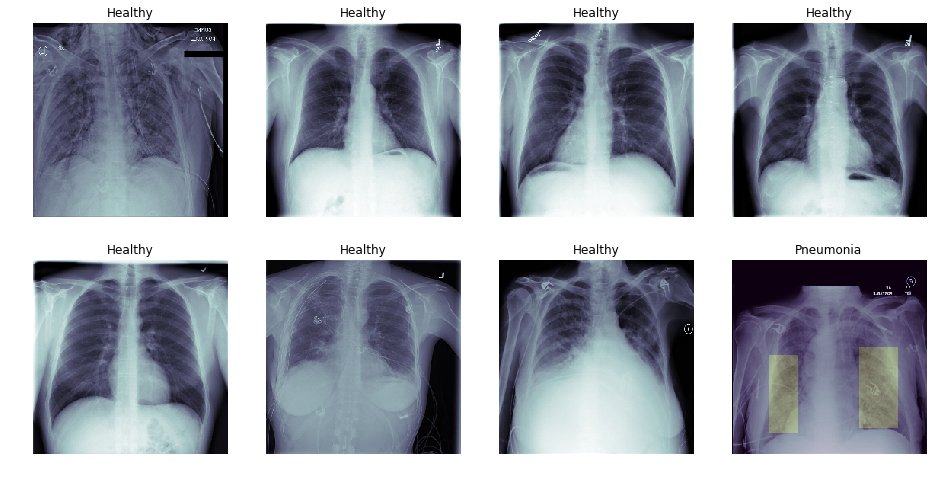

In [13]:
# @hidden_cell
box = grouped_bbox_df.loc[grouped_bbox_df['patientId'] == '7dd3bda8-4887-4621-8d9d-4638f7e8aed8']['bbox'].values[0]
folder = '../input/stage_1_train_images'
train_gen = generator(folder,
                      grouped_bbox_df,
                      train_ids,
                      batch_size=32,
                      image_size=256,
                      do_shuffle=True,
                      augment=True,
                      predict=False
                      )
valid_gen = generator(folder,
                      grouped_bbox_df,
                      valid_ids,
                      batch_size=32,
                      image_size=256,
                      do_shuffle=True,
                      augment=True,
                      predict=False
                      )

# Get a sample output from the generator to analyze
train_src, train_msk = train_gen.__getitem__(2)
valid_src, valid_msk = valid_gen.__getitem__(2)

# Display the sample
print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize=(16, 8))
for (source, mask, ax) in zip(train_src, train_msk, m_axs.flatten()):
    ax.imshow(source[:, :, 0], cmap='bone')
    title = ''
    if (mask==0).all():
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        ax.imshow(mask[:,:,0], alpha=0.2)
    ax.set_title('%s' % title)
    ax.axis('off')

In [14]:
# we create two instances with the same arguments
data_gen_args = dict(samplewise_center=False, 
                     samplewise_std_normalization=False, 
                     horizontal_flip = True, 
                     vertical_flip = False, 
                     height_shift_range = 0.05, 
                     width_shift_range = 0.02, 
                     rotation_range = 3, 
                     shear_range = 0.01,
                     fill_mode = 'nearest',
                     validation_split = 0.1,
                     zoom_range = 0.05,
                     preprocessing_function=preprocess_input
                    )
#data_gen_args = {}
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 2018

image_dir = dicom_dir + 'sources'
target_dir = dicom_dir + 'masks'

train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    subset='training')
train_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    subset='training')
valid_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    subset='validation')
valid_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    subset='validation')

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)

Found 23116 images belonging to 1 classes.
Found 23116 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.


(32, 256, 256, 3) (32, 256, 256, 3)


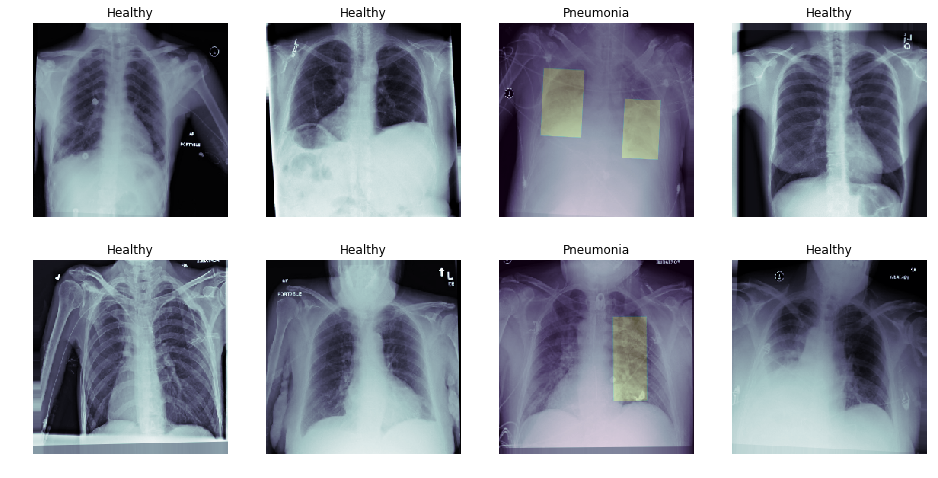

In [16]:
train_src, train_tar = next(train_generator)

print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (t_src, t_tar, ax) in zip(train_src, train_tar, m_axs.flatten()):
    ax.imshow(t_src[:,:,0], cmap = 'bone')
    if (t_tar<0).all():
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        # print(t_tar[:,:,0])
        ax.imshow(t_tar[:,:,0], alpha=0.2)
    ax.set_title('%s' % title)
    ax.axis('off')

In [18]:
print(train_src.shape[1:])
base_pretrained_model = PTModel(input_shape = train_src.shape[1:], 
                                include_top = False)
base_pretrained_model.trainable = False

(256, 256, 3)


In [24]:
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
#pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

#bn_features = BatchNormalization()(pt_features)
#gap = GlobalAveragePooling2D()(bn_features)
#gap_dr = Dropout(DROPOUT)(gap)
#dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
#dr_steps = BatchNormalization()(dr_steps)
#dr_steps = layers.LeakyReLU(0.1)(dr_steps)
#out_layer = Dense(train_tar.shape[1], activation = 'softmax')(dr_steps)

#attn_model = Model(inputs = [pt_features], 
#                   outputs = [out_layer], name = 'trained_model')



outputs = BatchNormalization(momentum=0.9)(pt_features)
outputs = LeakyReLU(0)(outputs)
outputs = Conv2D(1, 1, activation='sigmoid')(outputs)
outputs = UpSampling2D(32)(outputs)
model = Model(inputs=pt_features,
              outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 1)           1025      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 1)       0         
Total params: 5,121
Trainable params: 3,073
Non-trainable params: 2,048
_________________________________________________________________


In [25]:
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
#pneu_model.compile(optimizer = Adam(lr = LEARN_RATE),
#                    loss = 'categorical_crossentropy',
#                    metrics = ['categorical_accuracy'])
#pneu_model.summary()

NameError: name 'attn_model' is not defined

In [29]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
pneu_model.compile(optimizer='adam',
                   loss=iou_bce_loss,
                   metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [1]:
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

NameError: name 'ModelCheckpoint' is not defined

In [31]:
pneu_model.fit_generator(train_generator, 
                         steps_per_epoch=train_image_generator.n//BATCH_SIZE,
                         validation_data=valid_generator,
                         validation_steps=valid_image_generator.n//BATCH_SIZE,
                         epochs=20, 
                         callbacks=callbacks_list,
                         workers=2)

Epoch 1/20


InvalidArgumentError: Incompatible shapes: [6291456] vs. [2097152]
	 [[{{node loss_1/densenet121_loss/mul_1}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss_1/densenet121_loss/Reshape, loss_1/densenet121_loss/Reshape_1)]]
	 [[{{node metrics_1/acc/Mean/_5699}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4808_metrics_1/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]